In [1]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_train=pd.read_hdf('dftrain.h5')

In [3]:
df_test=pd.read_hdf('dfvalid.h5')

In [4]:
df_test_y=pd.read_csv('dfvalid_groundtruth.csv')

In [5]:
df_test_y=pd.merge(df_test_y,df_test,left_index=True,right_index=True)
df_test_y
fcols=df_test_y.columns[2:61141]

In [6]:
s1=df_test_y[df_test_y['seqID']==1][fcols].T

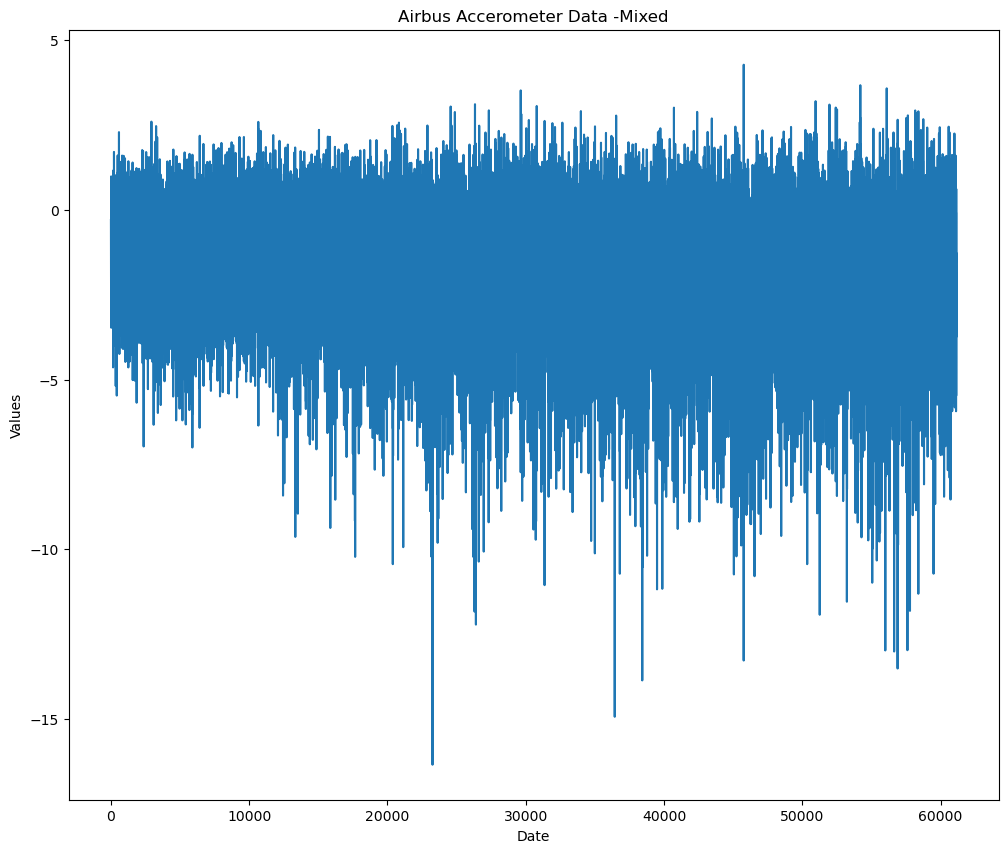

In [7]:
import matplotlib.pyplot as plt
 # Using a inbuilt style to change
# the look and feel of the plot
#plt.style.use("fivethirtyeight")

# setting figure size to 12, 10
plt.figure(figsize=(12, 10))

# Labelling the axes and setting
# a title
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Airbus Accerometer Data -Mixed")
plt.plot(np.array(s1))
#plt.plot(dataframe.rolling( window=2, min_periods=1).mean()["A"])

In [247]:
def down_sample_preprocess(df):
    dfret = pd.DataFrame()  # Initialize an empty DataFrame to store the processed data
    for i in range(0, len(df)):
        #print("Row: ", i)
        input = df[i:i + 1]  # Select a single row from the input DataFrame
        #print("Shape of input ",input.shape)
        data = input.copy()  # Create a copy of the selected row
        data = data.T  # Transpose the data (to have time series data in columns)
        data.index = pd.date_range(start='1/1/2018', periods=input.shape[1], freq='L')
        # Set the index of the transposed data as a date range starting from '1/1/2018',
        # with the number of periods equal to the length of the selected row, and with a frequency of 'L' (milliseconds)
        
        #print(data.head)
        df_t1 = data.resample('2048L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
        
        data_resample_mean = data.resample('2048L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        level_shift = (data_resample_mean - data_resample_mean.shift(-1)).interpolate()  # Perform a level shift operation on the resampled data
        df_t2 = level_shift.resample('2048L').max()  # Resample the level shifted data to a 1024L frequency and calculate the maximum
        df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
        
        df_t3 = data.resample('2048L').apply(lambda x: kurtosis(x))  # Resample the data to a 1024L frequency and apply the kurtosis function
        df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
        
        df_train_c = df_t1.join(df_t2).join(df_t3)  # Join the resampled dataframes into a single dataframe
        df_train_c['s'] = range(0, len(df_train_c))  # Add a new column 's' with values ranging from 0 to the length of the dataframe
        df_train_c['id'] = i  # Add a new column 'id' with the value of the current row index
        
        df2 = df_train_c.pivot_table(index=['id'], columns=['s'], values=['v_avg', 'v_shift', 'v_kurt'])  # Pivot the dataframe to reshape it
        df2 = df2.sort_index(axis=1, level=1)  # Sort the columns in ascending order
        
        df2.columns = [f'{x}_{y}' for x, y in df2.columns]  # Rename the columns with a combination of the original column names and the index level values
        df2 = df2.reset_index()  # Reset the index of the dataframe
        
        if (len(dfret) == 0):
            dfret = df2  # If the resulting dataframe is empty, assign it to dfret
        else:
            dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
        
    return dfret  # Return the processed dataframe

In [248]:
df_train_ds=down_sample_preprocess(df_train)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

In [249]:
feature_cols=df_train_ds.columns[1:]

In [250]:
feature_cols

Index(['v_avg_0', 'v_kurt_0', 'v_shift_0', 'v_avg_1', 'v_kurt_1', 'v_shift_1',
       'v_avg_2', 'v_kurt_2', 'v_shift_2', 'v_avg_3', 'v_kurt_3', 'v_shift_3',
       'v_avg_4', 'v_kurt_4', 'v_shift_4', 'v_avg_5', 'v_kurt_5', 'v_shift_5',
       'v_avg_6', 'v_kurt_6', 'v_shift_6', 'v_avg_7', 'v_kurt_7', 'v_shift_7',
       'v_avg_8', 'v_kurt_8', 'v_shift_8', 'v_avg_9', 'v_kurt_9', 'v_shift_9',
       'v_avg_10', 'v_kurt_10', 'v_shift_10', 'v_avg_11', 'v_kurt_11',
       'v_shift_11', 'v_avg_12', 'v_kurt_12', 'v_shift_12', 'v_avg_13',
       'v_kurt_13', 'v_shift_13', 'v_avg_14', 'v_kurt_14', 'v_shift_14',
       'v_avg_15', 'v_kurt_15', 'v_shift_15', 'v_avg_16', 'v_kurt_16',
       'v_shift_16', 'v_avg_17', 'v_kurt_17', 'v_shift_17', 'v_avg_18',
       'v_kurt_18', 'v_shift_18', 'v_avg_19', 'v_kurt_19', 'v_shift_19',
       'v_avg_20', 'v_kurt_20', 'v_shift_20', 'v_avg_21', 'v_kurt_21',
       'v_shift_21', 'v_avg_22', 'v_kurt_22', 'v_shift_22', 'v_avg_23',
       'v_kurt_23', 'v_shift_2

In [251]:
df_train.shape

(1677, 61440)

In [252]:
df_train_ds.shape

(1677, 91)

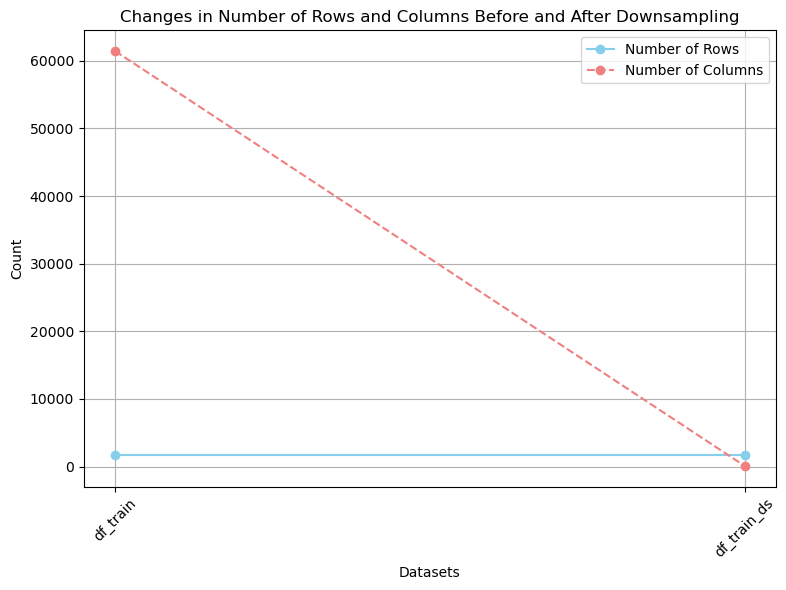

In [253]:
import matplotlib.pyplot as plt

# Extract the number of rows and columns for df_train and df_train_ds
rows_train, cols_train = df_train.shape
rows_train_ds, cols_train_ds = df_train_ds.shape

# Create lists to hold the data
datasets = ['df_train', 'df_train_ds']
rows = [rows_train, rows_train_ds]
cols = [cols_train, cols_train_ds]

# Create line plots
plt.figure(figsize=(8, 6))
plt.plot(datasets, rows, marker='o', label='Number of Rows', color='skyblue', linestyle='-')
plt.plot(datasets, cols, marker='o', label='Number of Columns', color='lightcoral', linestyle='--')

plt.xlabel('Datasets')
plt.ylabel('Count')
plt.title('Changes in Number of Rows and Columns Before and After Downsampling')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [254]:
import copy

X_train = copy.copy(df_train_ds[feature_cols])

In [255]:
df_test_ds=down_sample_preprocess (df_test)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_10444\3054456220.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

In [256]:
import copy
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

X_test = copy.copy(df_test_ds.drop('id', axis=1))
X_test

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_26,v_avg_27,v_kurt_27,v_shift_27,v_avg_28,v_kurt_28,v_shift_28,v_avg_29,v_kurt_29,v_shift_29
0,0.028891,-0.248347,0.036433,-0.007542,-0.031962,0.003784,-0.011325,0.147725,0.010099,-0.021424,...,0.001748,0.023304,-0.271101,0.002224,0.021080,0.002660,-0.002567,0.023647,-0.117479,-0.002567
0,-1.533344,-0.430126,-0.088610,-1.444734,-0.156967,0.160548,-1.605281,-0.139650,-0.036789,-1.568493,...,-0.060452,-2.298544,2.914535,-0.233174,-2.065369,2.246092,-0.180466,-1.884903,1.428274,-0.180466
0,-0.007497,-0.607686,0.001460,-0.008956,-0.727462,-0.000484,-0.008472,-0.273826,0.000204,-0.008676,...,-0.000518,-0.007961,-1.095714,0.001600,-0.009561,-1.113118,-0.003052,-0.006509,-0.960778,-0.003052
0,0.010959,0.977106,0.010581,0.000378,-0.221109,0.001078,-0.000700,-0.202088,-0.001475,0.000775,...,-0.001459,0.002015,-0.230270,0.001477,0.000538,-0.290222,0.000886,-0.000348,0.017526,0.000886
0,-8.391439,0.019198,0.614136,-9.005575,-0.076338,0.469204,-9.474779,0.018945,-0.726552,-8.748226,...,-0.411862,-6.110236,0.051164,-0.164790,-5.945445,0.276055,0.150920,-6.096366,0.310504,0.150920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-18.255630,-0.589996,0.103494,-18.359124,-1.407668,0.147645,-18.506768,-0.966629,0.074142,-18.580910,...,0.039223,-19.418877,-0.757628,0.047763,-19.466640,-0.433184,0.026777,-19.493417,-0.605999,0.026777
0,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000,-13.352138,...,0.000000,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000,-13.352138,-3.000000,0.000000
0,0.028682,-0.224219,0.003732,0.024950,-0.346075,0.001843,0.023108,0.065907,0.000066,0.023042,...,0.076230,0.191711,0.113576,0.025760,0.165951,0.034465,0.003536,0.162415,0.114578,0.003536
0,0.006286,-0.095399,0.002641,0.003644,-0.275869,-0.007697,0.011341,0.019503,-0.004483,0.015824,...,0.014106,-0.004808,-1.100707,-0.008148,0.003340,-1.037594,-0.041390,0.044730,-0.926771,-0.041390


In [257]:
X_train

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_26,v_avg_27,v_kurt_27,v_shift_27,v_avg_28,v_kurt_28,v_shift_28,v_avg_29,v_kurt_29,v_shift_29
0,0.039142,0.082738,0.000158,0.038984,-0.114852,-0.000577,0.039561,-0.026314,0.000548,0.039013,...,0.001189,0.038129,0.001613,-0.001044,0.039173,-0.277659,0.000046,0.039127,-0.014763,0.000046
0,0.005682,-1.252512,0.001392,0.004289,-1.013483,0.000707,0.003582,-1.452378,0.003015,0.000567,...,0.002824,0.001684,-1.443475,0.000618,0.001066,-1.415570,-0.002007,0.003073,-1.444962,-0.002007
0,0.005145,-0.754715,-0.011475,0.016619,-0.669953,0.007129,0.009490,-1.363982,-0.004378,0.013868,...,-0.003335,0.013769,-1.436060,-0.001302,0.015072,-1.430412,0.002242,0.012830,-1.443224,0.002242
0,0.005108,-0.986732,-0.000817,0.005925,-0.889680,0.001148,0.004777,0.304130,0.000336,0.004441,...,-0.001021,0.005061,-0.480948,-0.000723,0.005784,-0.181943,0.002098,0.003686,-0.365323,0.002098
0,0.029492,-1.408990,0.004205,0.025287,-1.463355,-0.009980,0.035267,-1.438308,0.004531,0.030736,...,0.024835,0.005704,-1.321140,-0.049865,0.055570,-0.984286,0.005606,0.049964,-1.253756,0.005606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.002212,-1.020951,0.003948,-0.006161,-1.258814,0.000821,-0.006981,-1.286996,-0.006505,-0.000476,...,-0.003935,-0.005724,-0.622157,0.003533,-0.009257,0.334730,-0.004183,-0.005074,0.192123,-0.004183
0,-0.098622,-1.143808,-0.030051,-0.068571,-1.009945,-0.044045,-0.024526,-0.852119,-0.008806,-0.015720,...,-0.001914,-0.041650,0.100091,-0.021628,-0.020022,8.046026,-0.016322,-0.003700,9.704546,-0.016322
0,-0.011027,-1.315232,0.020654,-0.031681,-1.283140,0.001916,-0.033597,-1.133041,0.007060,-0.040657,...,-0.000048,-0.027492,-0.894588,-0.003544,-0.023947,1.629726,-0.003294,-0.020654,6.308706,-0.003294
0,-0.026082,0.145217,-0.001345,-0.024737,0.110328,-0.005235,-0.019503,0.132654,0.000218,-0.019721,...,0.001888,-0.024500,-0.426736,0.000010,-0.024510,-0.057443,-0.001706,-0.022804,1.103013,-0.001706


In [258]:
y = df_test_y['anomaly'].values

# HMM

C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


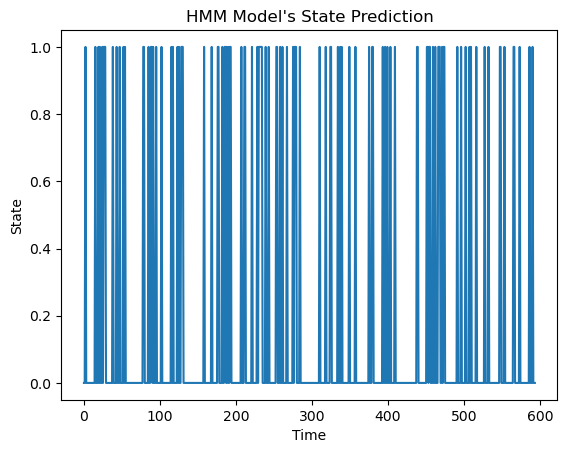

Reconstruction error: [ 0.  1. -1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1. -1.  1.  1.
  0. -1.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  1.  0. -1.  0.  0.  0.  1.  0.  1.  0.  0. -1.  0.  1.  0.  1. -1.  1.
  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.
  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0. -1.
  1. -1.  0.  0.  0. -1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  1. -1.  1.  0.  1.  0.  1.  0.  0.  0.
  1.  0.  0. -1. -1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  1.
  1.  1.  0.  1.  1.  1. -1.  1.  1.  1.  0.  1.  0.  1. -1. -1.  1.  1.
  0.  0. -1.  1.  1. -1. -1.  0. -1.  1.  0.  1.  0. -1.  0.  0.  0.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0. -1.  1.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  1. -1. -1.  0. -1.
 -1.  0.  0.  1.  1.  0.  1. 

In [259]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# Choose the number of hidden states
num_states = 2

# Create an HMM model
model = hmm.GaussianHMM(n_components=num_states, covariance_type="tied", random_state=42)

# Train the HMM model
model.fit(X_train)

# Generate a sequence of hidden states using the trained model
hidden_states = model.predict(X_test)

# Plot the predicted states
plt.plot(hidden_states)
plt.title("HMM Model's State Prediction")
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

# Calculate the reconstruction error as the Euclidean distance between the original and predicted observations

y = df_test_y['anomaly'].values
reconstruction_error = y - hidden_states
print("Reconstruction error:", reconstruction_error)

# Determine a threshold for anomaly detection
threshold = 0.5  # Adjust the threshold based on your requirements

# Apply the threshold to classify anomalies
y_hat_thresholded = np.where(reconstruction_error > threshold, 1, 0)

# Reshape y to match the shape of y_hat_thresholded
y = np.reshape(y, y_hat_thresholded.shape)

# Calculate accuracy rate
accuracy = np.sum(y == y_hat_thresholded) / len(y)
print("Accuracy rate:", accuracy)

# Calculate precision
precision = precision_score(y, y_hat_thresholded)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y, y_hat_thresholded)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y, y_hat_thresholded)
print("F1 score:", f1)


# VAE

In [328]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [329]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [330]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 90)]         0           []                               
                                                                                                  
 dense_114 (Dense)              (None, 45)           4095        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 30)           1380        ['dense_114[0][0]']              
                                                                                                  
 z_log_var (Dense)              (None, 30)           1380        ['dense_114[0][0]']              
                                                                                            

In [331]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_115 (Dense)           (None, 45)                1395      
                                                                 
 dense_116 (Dense)           (None, 90)                4140      
                                                                 
Total params: 5,535
Trainable params: 5,535
Non-trainable params: 0
_________________________________________________________________


In [332]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [333]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [334]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=300,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 90)]              0         
                                                                 
 encoder (Functional)        (None, 30)                6855      
                                                                 
 decoder (Functional)        (None, 90)                5535      
                                                                 
Total params: 12,390
Trainable params: 12,390
Non-trainable params: 0
_________________________________________________________________
Train on 1677 samples
Epoch 1/300
1677/1677 [==============================] - 7s 4ms/sample - loss: 37551067.3549
Epoch 2/300
1677/1677 [==============================] - 0s 85us/sample - loss: 7248009.4006
Epoch 3/300
1677/1677 [==============================] - 0s 92us/sample - loss: 2704669.3692
Epoch 4/300
1677/1

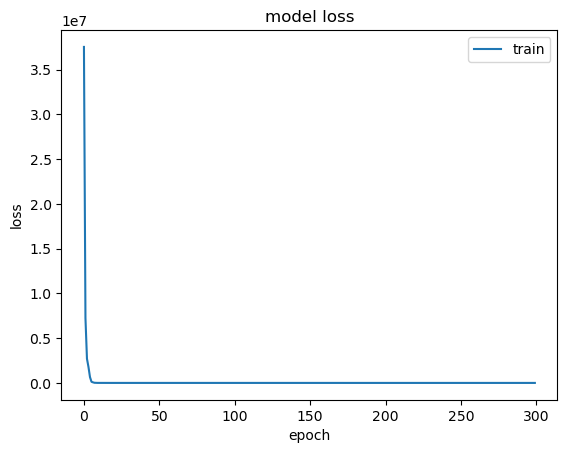

In [335]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [336]:
X_train_pred = vae_model.predict(X_train)

C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [337]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.16540381406384738
median error 0.13525765687294097
99Q: 0.4775324720946297
setting threshold on 0.4775324720946297 


In [338]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Assuming the 'predictions' variable contains the data with shape (594, 2880)
predictions=vae_model.predict(X_test)
# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
predictions_filled = imputer.fit_transform(predictions)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)
vector_reduced = pca.fit_transform(predictions_filled)

# Reshape the reduced vector to (594,)
Y_pred = vector_reduced.reshape(594,)

print(Y_pred.shape)
Y_pred


(594,)


array([-1.00196347e-01, -2.43581831e-01, -1.00438125e-01, -9.91282091e-02,
       -1.00452363e-01, -1.81939393e-01, -9.82249081e-02, -9.35121626e-02,
       -3.08861315e-01, -9.85929444e-02, -1.00448936e-01, -9.98259559e-02,
       -9.99353081e-02, -1.00445621e-01, -1.00452363e-01, -6.10638335e-02,
       -1.00452363e-01, -2.94881433e-01, -1.00116581e-01, -9.49142352e-02,
       -1.00384429e-01, -1.00452363e-01, -8.14856514e-02, -1.00420624e-01,
        5.33132648e+00, -1.35919884e-01, -9.82255042e-02, -2.20489442e-01,
       -1.00452363e-01, -9.11359042e-02, -6.66609406e-02, -8.55252147e-02,
       -2.13222414e-01, -5.80591559e-02, -1.00085497e-01, -1.00387909e-01,
       -1.00452363e-01, -3.74995545e-02, -9.00423899e-02, -9.68931541e-02,
       -9.96219739e-02, -9.97041985e-02, -1.00452363e-01, -1.00452363e-01,
       -2.86381274e-01, -9.13245827e-02, -9.97791588e-02, -1.00275733e-01,
       -9.96154547e-02, -9.98120829e-02, -9.97143090e-02, -1.00810826e-01,
       -9.90349799e-02, -

In [339]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Y_pred_sigmoid = sigmoid(Y_pred)
print(Y_pred_sigmoid)


[0.47497186 0.43940386 0.47491157 0.4752382  0.47490802 0.45464018
 0.47546348 0.476639   0.42339268 0.47537172 0.4749089  0.47506422
 0.47503695 0.4749097  0.47490802 0.48473877 0.47490802 0.42680925
 0.47499174 0.47628924 0.47492495 0.47490802 0.4796399  0.47491592
 0.9951857  0.46607226 0.4754634  0.44509983 0.47490802 0.47723174
 0.48334092 0.47863168 0.44689542 0.48548928 0.4749995  0.47492403
 0.47490802 0.4906262  0.4775046  0.47579563 0.47511506 0.47509456
 0.47490802 0.47490802 0.42889    0.47718474 0.4750759  0.47495207
 0.47511673 0.47506768 0.47509208 0.47481862 0.47526145 0.47490802
 0.47490802 0.47490802 0.4750202  0.47496998 0.43723318 0.4412366
 0.4755062  0.47490683 0.5674245  0.47490802 0.47496313 0.4756329
 0.47490802 0.47521132 0.47495222 0.43176374 0.47985992 0.4751443
 0.48661196 0.47490802 0.47819376 0.47491318 0.47502112 0.47146702
 0.47490802 0.47490802 0.46180752 0.47490802 0.47490802 0.45906365
 0.4750775  0.47490802 0.4834567  0.47491705 0.4749093  0.4790147

In [340]:
import numpy as np

mse = np.mean((Y_pred_sigmoid - y) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.2514782987269265


In [341]:
epsilon = 1e-15  # small value to avoid division by zero
loss = -(y * np.log(Y_pred_sigmoid + epsilon) + (1 - y) * np.log(1 - Y_pred_sigmoid + epsilon))#Binary Cross-Entropy Loss
mean_loss = np.mean(loss)
print("Binary Cross-Entropy Loss:", mean_loss)
loss

Binary Cross-Entropy Loss: 0.6924005392813422


array([0.6443035 , 0.82233632, 0.64418858, 0.64481086, 0.74463415,
       0.78824902, 0.64524031, 0.64748389, 0.85945523, 0.64506531,
       0.64418346, 0.64447933, 0.74436271, 0.74463063, 0.74463415,
       0.66308129, 0.74463415, 0.85141808, 0.64434129, 0.64681578,
       0.64421403, 0.74463415, 0.65323418, 0.64419687, 0.00482595,
       0.76341456, 0.64524007, 0.80945671, 0.74463415, 0.64861703,
       0.66037202, 0.65129852, 0.80543065, 0.6645388 , 0.64435601,
       0.64421231, 0.74463415, 0.67457318, 0.64913911, 0.64587367,
       0.64457619, 0.64453715, 0.74463415, 0.74463415, 0.84655482,
       0.64852715, 0.64450163, 0.64426577, 0.64457941, 0.74429804,
       0.64453238, 0.74482238, 0.64485514, 0.74463415, 0.74463415,
       0.74463415, 0.64439541, 0.74450368, 0.82728863, 0.81817406,
       0.64532167, 0.74463665, 0.83799833, 0.74463415, 0.64428681,
       0.6455633 , 0.74463415, 0.74399567, 0.64426601, 0.83987677,
       0.6536572 , 0.64463186, 0.66672331, 0.74463415, 0.73773

In [353]:
error_thresh=0.7
anomalies = (loss > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.48653198653198654

In [354]:
from sklearn.metrics import classification_report
print(classification_report(y, anomalies))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       297
         1.0       0.98      0.95      0.97       297

    accuracy                           0.97       594
   macro avg       0.97      0.97      0.97       594
weighted avg       0.97      0.97      0.97       594



# RNN Based VAE

In [279]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [280]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [281]:
from keras.layers import LSTM, BatchNormalization, Dropout

inputs = Input(shape=input_shape, name='encoder_input')
x = Reshape((1, input_shape[0]))(inputs)
x = LSTM(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, z, name='encoder_RVAE')
encoder.summary()

Model: "encoder_RVAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 90)]         0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 1, 90)        0           ['encoder_input[0][0]']          
                                                                                                  
 lstm_4 (LSTM)                  (None, 45)           24480       ['reshape_4[0][0]']              
                                                                                                  
 batch_normalization_16 (BatchN  (None, 45)          180         ['lstm_4[0][0]']                 
 ormalization)                                                                         

In [282]:
# decoder model
from keras.layers import LSTM, BatchNormalization, Dropout

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Reshape((1, intermediate_dim))(x)
x = LSTM(intermediate_dim, activation='relu', return_sequences=True)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder_RVAE')
decoder.summary()


Model: "decoder_RVAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_88 (Dense)            (None, 45)                1395      
                                                                 
 reshape_5 (Reshape)         (None, 1, 45)             0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 45)             16380     
                                                                 
 batch_normalization_17 (Bat  (None, 1, 45)            180       
 chNormalization)                                                
                                                                 
 dropout_47 (Dropout)        (None, 1, 45)             0         
                                                      

In [283]:
# full VAE model
outputs = decoder(encoder(inputs))
rvae_model = Model(inputs, outputs, name='RNN_vae_mlp')

In [284]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [285]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

rvae_model.compile(optimizer=opt, loss=vae_loss)
rvae_model.summary()
# Finally, we train the model:
results = rvae_model.fit(X_train, X_train,
                        shuffle=False,
                        epochs=100,
                        batch_size=64)

Model: "RNN_vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 90)]              0         
                                                                 
 encoder_RVAE (Functional)   (None, 30)                27420     
                                                                 
 decoder_RVAE (Functional)   (None, 90)                22095     
                                                                 
Total params: 49,515
Trainable params: 49,335
Non-trainable params: 180
_________________________________________________________________
Train on 1677 samples
Epoch 1/100
1677/1677 [==============================] - 8s 5ms/sample - loss: 1727149.9312
Epoch 2/100
1677/1677 [==============================] - 0s 93us/sample - loss: 4267840.2485
Epoch 3/100
1677/1677 [==============================] - 0s 91us/sample - loss: 1176415766.7141
Epoch 4/10

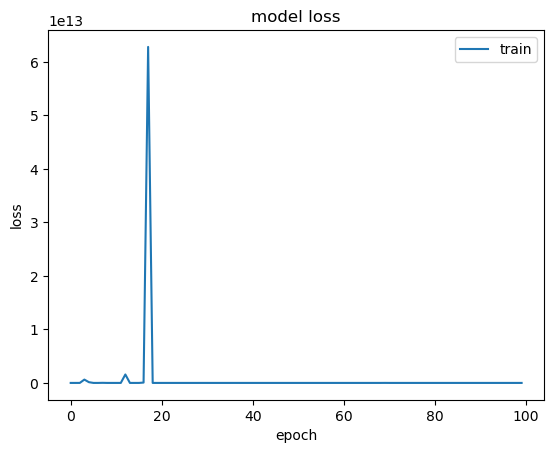

In [286]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [287]:
X_train_pred = rvae_model.predict(X_train)

C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [288]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.22572911575692883
median error 0.17723752397855713
99Q: 0.8348251520237796
setting threshold on 0.8348251520237796 


In [289]:
error_thresh

0.8348251520237796

In [290]:
y

array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0.

In [291]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Assuming the 'predictions' variable contains the data with shape (594, 2880)
predictions=rvae_model.predict(X_test)


In [292]:
predictions.shape

(594, 90)

In [293]:
y.shape

(594,)

In [294]:
# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
predictions_filled = imputer.fit_transform(predictions)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)
vector_reduced = pca.fit_transform(predictions_filled)

# Reshape the reduced vector to (594,)
Y_pred = vector_reduced.reshape(594,)

print(Y_pred.shape)
Y_pred


(594,)


array([-2.1347547 , -1.7077458 , -2.2284002 , -2.1701794 ,  6.751747  ,
        6.7078586 , -2.2448876 , -2.2121937 , -1.5058339 , -2.183397  ,
       -2.2198782 , -2.2184558 , -0.91594666, -2.2354372 ,  6.757523  ,
       -2.250014  ,  6.5432796 ,  1.44116   , -2.1695278 , -2.244219  ,
       -2.238111  , -1.1848855 , -2.2435384 , -2.2159007 ,  6.757523  ,
        6.7391105 , -2.256928  ,  5.7960987 ,  6.1775584 , -2.2319336 ,
       -2.1145756 , -2.1899118 , -1.9371996 , -2.2346878 , -2.1322749 ,
       -2.2199588 ,  6.670905  , -2.246494  , -2.229759  , -2.1820478 ,
       -2.2714758 , -2.2177005 , -2.3308558 , -1.8356736 , -1.3612928 ,
       -2.2281754 , -2.2351687 , -2.2859173 , -2.2276309 ,  2.0915275 ,
       -2.1932745 ,  2.2822397 , -2.2209876 ,  6.5739555 ,  5.7606235 ,
       -2.2236528 , -2.1798077 ,  6.703391  , -1.7590857 , -1.9804832 ,
       -2.141169  ,  6.757523  , -2.2161345 ,  6.757523  , -2.2065883 ,
       -2.2091758 ,  6.757523  , -2.2231042 , -2.2587092 , -1.94

In [295]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Y_pred_sigmoid = sigmoid(Y_pred)
print(Y_pred_sigmoid)


[0.10576446 0.15345633 0.09722897 0.10246053 0.9988325  0.9987802
 0.09579136 0.09866082 0.18155703 0.10125138 0.09797957 0.09810535
 0.2857845  0.09661305 0.9988393  0.09534825 0.9985623  0.8086342
 0.10252047 0.09584928 0.09637993 0.2341749  0.09590829 0.09833166
 0.9988393  0.9988176  0.09475355 0.9969699  0.99792886 0.09691927
 0.1076882  0.10066008 0.12595583 0.09667847 0.10599922 0.09797245
 0.9987344  0.09565231 0.09710977 0.10137422 0.09351303 0.0981722
 0.08859953 0.13756377 0.20403026 0.0972487  0.09663648 0.09229602
 0.09729652 0.890077   0.10035606 0.90739536 0.09788157 0.99860567
 0.99686074 0.09764647 0.10157848 0.9987747  0.1469049  0.12126734
 0.10515932 0.9988393  0.09831093 0.9988393  0.09916042 0.09892952
 0.9988393  0.09769482 0.09460087 0.12526521 0.10075458 0.09875761
 0.1040823  0.12381741 0.09950311 0.09864397 0.09822329 0.10118473
 0.99883085 0.12594761 0.83877295 0.99871755 0.9987344  0.9988393
 0.09667806 0.9988393  0.09784926 0.09562325 0.09618018 0.10037329

In [296]:
import numpy as np

mse = np.mean((Y_pred_sigmoid - y) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.19206320396724522


In [297]:
epsilon = 1e-15  # small value to avoid division by zero
loss = -(y * np.log(Y_pred_sigmoid + epsilon) + (1 - y) * np.log(1 - Y_pred_sigmoid + epsilon))#Binary Cross-Entropy Loss
mean_loss = np.mean(loss)
print("Binary Cross-Entropy Loss:", mean_loss)
loss

Binary Cross-Entropy Loss: 0.5904107917733616


array([1.11786060e-01, 1.87433922e+00, 1.02286294e-01, 1.08098149e-01,
       1.16815825e-03, 1.22055365e-03, 1.00695126e-01, 1.03873648e-01,
       1.70618546e+00, 1.06751889e-01, 1.03118084e-01, 1.03257582e-01,
       1.25251722e+00, 2.33704138e+00, 1.16135541e-03, 1.00205205e-01,
       1.43875810e-03, 2.12408602e-01, 1.08164959e-01, 1.00759201e-01,
       1.01346292e-01, 1.45168698e+00, 1.00824468e-01, 1.03508554e-01,
       1.16135541e-03, 1.18307688e-03, 9.95480642e-02, 3.03472136e-03,
       2.07329006e-03, 1.01943359e-01, 1.13939643e-01, 1.06094211e-01,
       2.07182384e+00, 1.01676747e-01, 1.12048641e-01, 1.03110217e-01,
       1.26638694e-03, 1.00541413e-01, 1.02154322e-01, 1.06888585e-01,
       9.81786028e-02, 1.03331670e-01, 2.42362881e+00, 1.98366773e+00,
       1.58948696e+00, 1.02308147e-01, 1.01630233e-01, 9.68369469e-02,
       1.02361172e-01, 1.16447307e-01, 1.05756193e-01, 9.71770212e-02,
       1.03009455e-01, 1.39530445e-03, 3.14419530e-03, 2.32640171e+00,
      

In [298]:
#error_thresh=0.4
anomalies = (loss > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.24242424242424243

In [299]:

from sklearn.metrics import classification_report
print(classification_report(y, anomalies))

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78       297
         1.0       0.97      0.47      0.63       297

    accuracy                           0.73       594
   macro avg       0.81      0.73      0.71       594
weighted avg       0.81      0.73      0.71       594



# GAN

In [312]:
X_train.shape

(1677, 90)

In [313]:
indim=X_train.shape[1]

In [314]:
# Defining the Generator network
from tensorflow.keras.layers import Dropout, BatchNormalization
def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=indim, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(indim, activation='tanh'))
    # Add dropout and batch normalization
    generator.add(Dropout(0.3))
    generator.add(BatchNormalization())
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [315]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=indim, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
    # Add dropout and batch normalization
    discriminator.add(Dropout(0.3))
    discriminator.add(BatchNormalization())
    
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

In [316]:
# Defining the Encoder network
def get_encoder(optimizer):
    encoder_input = Input(shape=(64,))
    x = Dense(128, activation='relu')(encoder_input)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    encoder_output = Dense(64, activation='tanh')(x)
    
    # Add batch normalization
    encoder_output = BatchNormalization()(encoder_output)
    
    encoder = Model(inputs=encoder_input, outputs=encoder_output)
    encoder.compile(loss='binary_crossentropy', optimizer=optimizer)
    return encoder

In [317]:
def get_gan_network(discriminator, generator, optimizer,input_dim=indim):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input) 
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [318]:
learning_rate = 0.0001
batch_size = 32
epochs = 100
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

In [319]:
#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=indim)

In [320]:
#Calculating the number of batches based on the batch size
from tqdm import tqdm
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=indim)


for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,indim])

        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)

        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]

        X = np.vstack((generated_images,image_batch))
        y_dis = np.ones(2*batch_size)
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, indim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)

    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))



100%|██████████| 5200/5200 [2:51:41<00:00,  1.98s/it]

  0%|          | 1/5200 [00:01<1:30:52,  1.05s/it]C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,

  1%|          | 57/5200 [00:24<04:08, 20.68it/s]

Epoch 0 Batch 51/52 [D loss: 3.959870] [G loss:5.719496]



  2%|▏         | 112/5200 [00:25<01:48, 46.93it/s]

Epoch 1 Batch 51/52 [D loss: 2.048594] [G loss:11.771712]



  3%|▎         | 162/5200 [00:26<01:47, 46.77it/s]

Epoch 2 Batch 51/52 [D loss: 3.395667] [G loss:12.406809]



  4%|▍         | 217/5200 [00:27<01:44, 47.77it/s]

Epoch 3 Batch 51/52 [D loss: 1.502409] [G loss:12.035046]



  5%|▌         | 267/5200 [00:28<01:44, 47.38it/s]

Epoch 4 Batch 51/52 [D loss: 0.829732] [G loss:11.108759]



  6%|▌         | 317/5200 [00:29<01:41, 47.90it/s]

Epoch 5 Batch 51/52 [D loss: 3.135007] [G loss:10.815796]



  7%|▋         | 372/5200 [00:30<01:40, 47.89it/s]

Epoch 6 Batch 51/52 [D loss: 2.434811] [G loss:9.010688]



  8%|▊         | 422/5200 [00:31<01:38, 48.37it/s]


Epoch 7 Batch 51/52 [D loss: 2.175261] [G loss:10.039234]


  9%|▉         | 477/5200 [00:32<01:41, 46.60it/s]

Epoch 8 Batch 51/52 [D loss: 1.701279] [G loss:9.597439]



 10%|█         | 528/5200 [00:33<01:37, 48.06it/s]

Epoch 9 Batch 51/52 [D loss: 1.693414] [G loss:9.650953]



 11%|█         | 578/5200 [00:34<01:35, 48.53it/s]


Epoch 10 Batch 51/52 [D loss: 2.178339] [G loss:8.833286]


 12%|█▏        | 633/5200 [00:36<01:33, 49.00it/s]

Epoch 11 Batch 51/52 [D loss: 2.415132] [G loss:6.228583]



 13%|█▎        | 683/5200 [00:37<01:33, 48.25it/s]

Epoch 12 Batch 51/52 [D loss: 1.694140] [G loss:8.162936]



 14%|█▍        | 733/5200 [00:38<01:32, 48.30it/s]


Epoch 13 Batch 51/52 [D loss: 1.935906] [G loss:7.535146]


 15%|█▌        | 788/5200 [00:39<01:31, 48.38it/s]

Epoch 14 Batch 51/52 [D loss: 2.180245] [G loss:7.275901]



 16%|█▌        | 838/5200 [00:40<01:30, 48.39it/s]

Epoch 15 Batch 51/52 [D loss: 1.455081] [G loss:8.216232]



 17%|█▋        | 893/5200 [00:41<01:28, 48.76it/s]

Epoch 16 Batch 51/52 [D loss: 2.413296] [G loss:7.725220]



 18%|█▊        | 943/5200 [00:42<01:27, 48.54it/s]

Epoch 17 Batch 51/52 [D loss: 1.932006] [G loss:9.108210]



 19%|█▉        | 998/5200 [00:43<01:26, 48.79it/s]

Epoch 18 Batch 51/52 [D loss: 2.169421] [G loss:7.369158]



 20%|██        | 1048/5200 [00:44<01:25, 48.41it/s]

Epoch 19 Batch 51/52 [D loss: 2.169133] [G loss:7.175157]



 21%|██        | 1098/5200 [00:45<01:23, 48.84it/s]


Epoch 20 Batch 51/52 [D loss: 2.169133] [G loss:6.674002]


 22%|██▏       | 1153/5200 [00:46<01:22, 48.96it/s]

Epoch 21 Batch 51/52 [D loss: 1.691959] [G loss:7.630304]



 23%|██▎       | 1203/5200 [00:47<01:22, 48.42it/s]

Epoch 22 Batch 51/52 [D loss: 3.856237] [G loss:9.042679]



 24%|██▍       | 1253/5200 [00:48<01:24, 46.90it/s]


Epoch 23 Batch 51/52 [D loss: 2.892685] [G loss:8.641211]


 25%|██▌       | 1308/5200 [00:50<01:22, 47.44it/s]

Epoch 24 Batch 51/52 [D loss: 2.653979] [G loss:10.400909]



 26%|██▌       | 1358/5200 [00:51<01:20, 47.63it/s]

Epoch 25 Batch 51/52 [D loss: 2.892178] [G loss:7.966857]



 27%|██▋       | 1413/5200 [00:52<01:20, 47.31it/s]

Epoch 26 Batch 51/52 [D loss: 2.656184] [G loss:9.096244]



 28%|██▊       | 1463/5200 [00:53<01:18, 47.54it/s]

Epoch 27 Batch 51/52 [D loss: 2.410148] [G loss:8.210842]



 29%|██▉       | 1513/5200 [00:54<01:19, 46.48it/s]


Epoch 28 Batch 51/52 [D loss: 3.133193] [G loss:9.111040]


 30%|███       | 1568/5200 [00:55<01:15, 48.10it/s]

Epoch 29 Batch 51/52 [D loss: 1.928203] [G loss:6.439551]



 31%|███       | 1618/5200 [00:56<01:13, 48.50it/s]

Epoch 30 Batch 51/52 [D loss: 1.930506] [G loss:7.698613]



 32%|███▏      | 1673/5200 [00:57<01:12, 48.70it/s]

Epoch 31 Batch 51/52 [D loss: 1.454356] [G loss:7.295625]



 33%|███▎      | 1723/5200 [00:58<01:11, 48.51it/s]

Epoch 32 Batch 51/52 [D loss: 3.374207] [G loss:10.035011]



 34%|███▍      | 1778/5200 [00:59<01:10, 48.41it/s]

Epoch 33 Batch 51/52 [D loss: 3.133193] [G loss:10.333572]



 35%|███▌      | 1828/5200 [01:00<01:10, 47.69it/s]

Epoch 34 Batch 51/52 [D loss: 1.692977] [G loss:8.266723]



 36%|███▌      | 1878/5200 [01:01<01:08, 48.32it/s]


Epoch 35 Batch 51/52 [D loss: 3.374207] [G loss:11.849830]


 37%|███▋      | 1933/5200 [01:03<01:07, 48.70it/s]

Epoch 36 Batch 51/52 [D loss: 2.892178] [G loss:9.862648]



 38%|███▊      | 1983/5200 [01:04<01:07, 47.39it/s]

Epoch 37 Batch 51/52 [D loss: 2.653271] [G loss:12.119671]



 39%|███▉      | 2033/5200 [01:05<01:08, 46.48it/s]


Epoch 38 Batch 51/52 [D loss: 2.170969] [G loss:9.956845]


 40%|████      | 2088/5200 [01:06<01:04, 48.32it/s]

Epoch 39 Batch 51/52 [D loss: 2.174503] [G loss:12.439316]



 41%|████      | 2138/5200 [01:07<01:02, 48.68it/s]


Epoch 40 Batch 51/52 [D loss: 3.137362] [G loss:10.984133]


 42%|████▏     | 2193/5200 [01:08<01:02, 47.74it/s]

Epoch 41 Batch 51/52 [D loss: 1.929443] [G loss:9.793775]



 43%|████▎     | 2243/5200 [01:09<01:06, 44.56it/s]

Epoch 42 Batch 51/52 [D loss: 2.169133] [G loss:9.230001]



 44%|████▍     | 2293/5200 [01:10<01:01, 46.92it/s]


Epoch 43 Batch 51/52 [D loss: 1.687104] [G loss:11.052080]


 45%|████▌     | 2348/5200 [01:11<01:01, 46.06it/s]

Epoch 44 Batch 51/52 [D loss: 1.214425] [G loss:9.453007]



 46%|████▌     | 2398/5200 [01:12<00:58, 47.72it/s]

Epoch 45 Batch 51/52 [D loss: 1.928119] [G loss:10.782126]



 47%|████▋     | 2453/5200 [01:14<00:58, 47.09it/s]

Epoch 46 Batch 51/52 [D loss: 2.169133] [G loss:8.746008]



 48%|████▊     | 2503/5200 [01:15<00:57, 47.08it/s]

Epoch 47 Batch 51/52 [D loss: 3.133193] [G loss:10.044109]



 49%|████▉     | 2558/5200 [01:16<00:54, 48.29it/s]

Epoch 48 Batch 51/52 [D loss: 1.689255] [G loss:10.678312]



 50%|█████     | 2608/5200 [01:17<00:53, 48.50it/s]

Epoch 49 Batch 51/52 [D loss: 2.892178] [G loss:11.049044]



 51%|█████     | 2658/5200 [01:18<00:52, 48.34it/s]


Epoch 50 Batch 51/52 [D loss: 2.657672] [G loss:10.533316]


 52%|█████▏    | 2713/5200 [01:19<00:52, 47.73it/s]

Epoch 51 Batch 51/52 [D loss: 2.651163] [G loss:10.960598]



 53%|█████▎    | 2763/5200 [01:20<00:52, 46.04it/s]

Epoch 52 Batch 51/52 [D loss: 2.666304] [G loss:10.982058]



 54%|█████▍    | 2813/5200 [01:21<00:52, 45.58it/s]


Epoch 53 Batch 51/52 [D loss: 2.410148] [G loss:10.929399]


 55%|█████▌    | 2868/5200 [01:22<00:51, 45.36it/s]

Epoch 54 Batch 51/52 [D loss: 2.169133] [G loss:10.408477]



 56%|█████▌    | 2918/5200 [01:23<00:48, 47.21it/s]

Epoch 55 Batch 51/52 [D loss: 2.410148] [G loss:11.277756]



 57%|█████▋    | 2973/5200 [01:25<00:47, 46.96it/s]

Epoch 56 Batch 51/52 [D loss: 3.856237] [G loss:8.276466]



 58%|█████▊    | 3023/5200 [01:26<00:46, 46.34it/s]

Epoch 57 Batch 51/52 [D loss: 2.169133] [G loss:10.432159]



 59%|█████▉    | 3073/5200 [01:27<00:44, 48.20it/s]


Epoch 58 Batch 51/52 [D loss: 2.169133] [G loss:10.743593]


 60%|██████    | 3128/5200 [01:28<00:42, 48.34it/s]

Epoch 59 Batch 51/52 [D loss: 1.446089] [G loss:9.532982]



 61%|██████    | 3178/5200 [01:29<00:41, 48.44it/s]

Epoch 60 Batch 51/52 [D loss: 2.892178] [G loss:8.774313]



 62%|██████▏   | 3233/5200 [01:30<00:40, 48.38it/s]

Epoch 61 Batch 51/52 [D loss: 2.410148] [G loss:10.047443]



 63%|██████▎   | 3283/5200 [01:31<00:39, 48.35it/s]

Epoch 62 Batch 51/52 [D loss: 1.687104] [G loss:10.953161]



 64%|██████▍   | 3333/5200 [01:32<00:38, 48.54it/s]


Epoch 63 Batch 51/52 [D loss: 3.374207] [G loss:9.661407]


 65%|██████▌   | 3388/5200 [01:33<00:39, 46.22it/s]

Epoch 64 Batch 51/52 [D loss: 2.669050] [G loss:9.611807]



 66%|██████▌   | 3438/5200 [01:34<00:38, 46.17it/s]

Epoch 65 Batch 51/52 [D loss: 2.169133] [G loss:11.804458]



 67%|██████▋   | 3493/5200 [01:35<00:35, 48.45it/s]

Epoch 66 Batch 51/52 [D loss: 2.899158] [G loss:10.066346]



 68%|██████▊   | 3543/5200 [01:37<00:36, 45.80it/s]

Epoch 67 Batch 51/52 [D loss: 2.651163] [G loss:10.401462]



 69%|██████▉   | 3593/5200 [01:38<00:33, 47.61it/s]

Epoch 68 Batch 51/52 [D loss: 1.687104] [G loss:10.009083]



 70%|███████   | 3648/5200 [01:39<00:32, 47.92it/s]

Epoch 69 Batch 51/52 [D loss: 2.651163] [G loss:11.435356]



 71%|███████   | 3698/5200 [01:40<00:31, 48.17it/s]


Epoch 70 Batch 51/52 [D loss: 1.447247] [G loss:12.711996]


 72%|███████▏  | 3753/5200 [01:41<00:30, 48.16it/s]

Epoch 71 Batch 51/52 [D loss: 2.169917] [G loss:14.502457]



 73%|███████▎  | 3803/5200 [01:42<00:29, 47.94it/s]

Epoch 72 Batch 51/52 [D loss: 1.931281] [G loss:13.870129]



 74%|███████▍  | 3853/5200 [01:43<00:28, 47.81it/s]

Epoch 73 Batch 51/52 [D loss: 2.892178] [G loss:14.576925]



 75%|███████▌  | 3908/5200 [01:44<00:27, 47.61it/s]

Epoch 74 Batch 51/52 [D loss: 2.659236] [G loss:13.361293]



 76%|███████▌  | 3958/5200 [01:45<00:25, 48.30it/s]


Epoch 75 Batch 51/52 [D loss: 1.928118] [G loss:12.376643]


 77%|███████▋  | 4013/5200 [01:46<00:24, 48.18it/s]

Epoch 76 Batch 51/52 [D loss: 1.447129] [G loss:14.126664]



 78%|███████▊  | 4063/5200 [01:47<00:23, 48.61it/s]

Epoch 77 Batch 51/52 [D loss: 2.662010] [G loss:12.756989]



 79%|███████▉  | 4118/5200 [01:49<00:22, 48.12it/s]

Epoch 78 Batch 51/52 [D loss: 1.207422] [G loss:13.794584]



 80%|████████  | 4168/5200 [01:50<00:21, 48.04it/s]

Epoch 79 Batch 51/52 [D loss: 2.892178] [G loss:12.013348]



 81%|████████  | 4218/5200 [01:51<00:20, 48.38it/s]

Epoch 80 Batch 51/52 [D loss: 2.169133] [G loss:12.806728]



 82%|████████▏ | 4273/5200 [01:52<00:19, 46.55it/s]

Epoch 81 Batch 51/52 [D loss: 2.428066] [G loss:12.345724]



 83%|████████▎ | 4323/5200 [01:53<00:18, 47.42it/s]

Epoch 82 Batch 51/52 [D loss: 1.446620] [G loss:14.566752]



 84%|████████▍ | 4373/5200 [01:54<00:17, 48.60it/s]


Epoch 83 Batch 51/52 [D loss: 1.689633] [G loss:14.082934]


 85%|████████▌ | 4428/5200 [01:55<00:15, 48.39it/s]

Epoch 84 Batch 51/52 [D loss: 3.615222] [G loss:11.913002]



 86%|████████▌ | 4478/5200 [01:56<00:14, 48.69it/s]


Epoch 85 Batch 51/52 [D loss: 3.133193] [G loss:13.233923]


 87%|████████▋ | 4533/5200 [01:57<00:13, 48.49it/s]

Epoch 86 Batch 51/52 [D loss: 3.133193] [G loss:12.241013]



 88%|████████▊ | 4583/5200 [01:58<00:12, 48.23it/s]

Epoch 87 Batch 51/52 [D loss: 1.942600] [G loss:12.677834]



 89%|████████▉ | 4633/5200 [01:59<00:12, 46.90it/s]


Epoch 88 Batch 51/52 [D loss: 1.690215] [G loss:13.226531]


 90%|█████████ | 4689/5200 [02:00<00:10, 48.63it/s]

Epoch 89 Batch 51/52 [D loss: 1.206880] [G loss:11.172382]



 91%|█████████ | 4739/5200 [02:02<00:09, 48.43it/s]

Epoch 90 Batch 51/52 [D loss: 1.928118] [G loss:12.550922]



 92%|█████████▏| 4794/5200 [02:03<00:08, 48.43it/s]

Epoch 91 Batch 51/52 [D loss: 3.374207] [G loss:13.739038]



 93%|█████████▎| 4844/5200 [02:04<00:07, 48.35it/s]

Epoch 92 Batch 51/52 [D loss: 3.374207] [G loss:12.716597]



 94%|█████████▍| 4894/5200 [02:05<00:06, 48.11it/s]

Epoch 93 Batch 51/52 [D loss: 3.382880] [G loss:12.721352]



 95%|█████████▌| 4949/5200 [02:06<00:05, 48.10it/s]

Epoch 94 Batch 51/52 [D loss: 1.692922] [G loss:12.742146]



 96%|█████████▌| 4999/5200 [02:07<00:04, 48.43it/s]

Epoch 95 Batch 51/52 [D loss: 1.454635] [G loss:12.088028]



 97%|█████████▋| 5049/5200 [02:08<00:03, 46.11it/s]


Epoch 96 Batch 51/52 [D loss: 2.410148] [G loss:12.794596]


 98%|█████████▊| 5105/5200 [02:09<00:01, 47.57it/s]

Epoch 97 Batch 51/52 [D loss: 2.410148] [G loss:14.564867]



 99%|█████████▉| 5155/5200 [02:10<00:00, 48.48it/s]

Epoch 98 Batch 51/52 [D loss: 2.892178] [G loss:13.161165]



100%|██████████| 5200/5200 [02:11<00:00, 48.48it/s]

Epoch 99 Batch 51/52 [D loss: 2.894629] [G loss:11.596525]


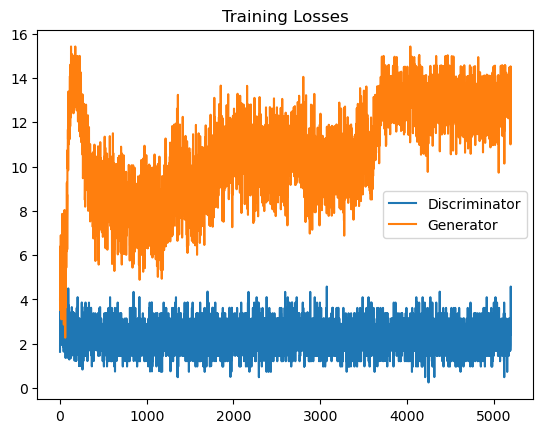

In [321]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [322]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=32,verbose=0)
        results = np.append(results, tmp_rslt)

In [323]:
X_test.shape

(594, 90)

In [324]:
results.shape

(594,)

In [325]:
#Obtaining the lowest 1% score
per = np.percentile(results,12.5)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [326]:
from sklearn.metrics import classification_report


# Predictions on the test set
nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=32,verbose=0)
        results = np.append(results, tmp_rslt)

# Convert results to binary class labels
binary_results = (results > 0.476).astype(int)

# Obtain ground truth labels
true_labels = np.zeros_like(binary_results)
true_labels[:results.shape[0]] = 1

# Calculate classification report
report = classification_report(true_labels, binary_results)
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97       594

    accuracy                           0.94       594
   macro avg       0.50      0.47      0.48       594
weighted avg       1.00      0.94      0.97       594



C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix :


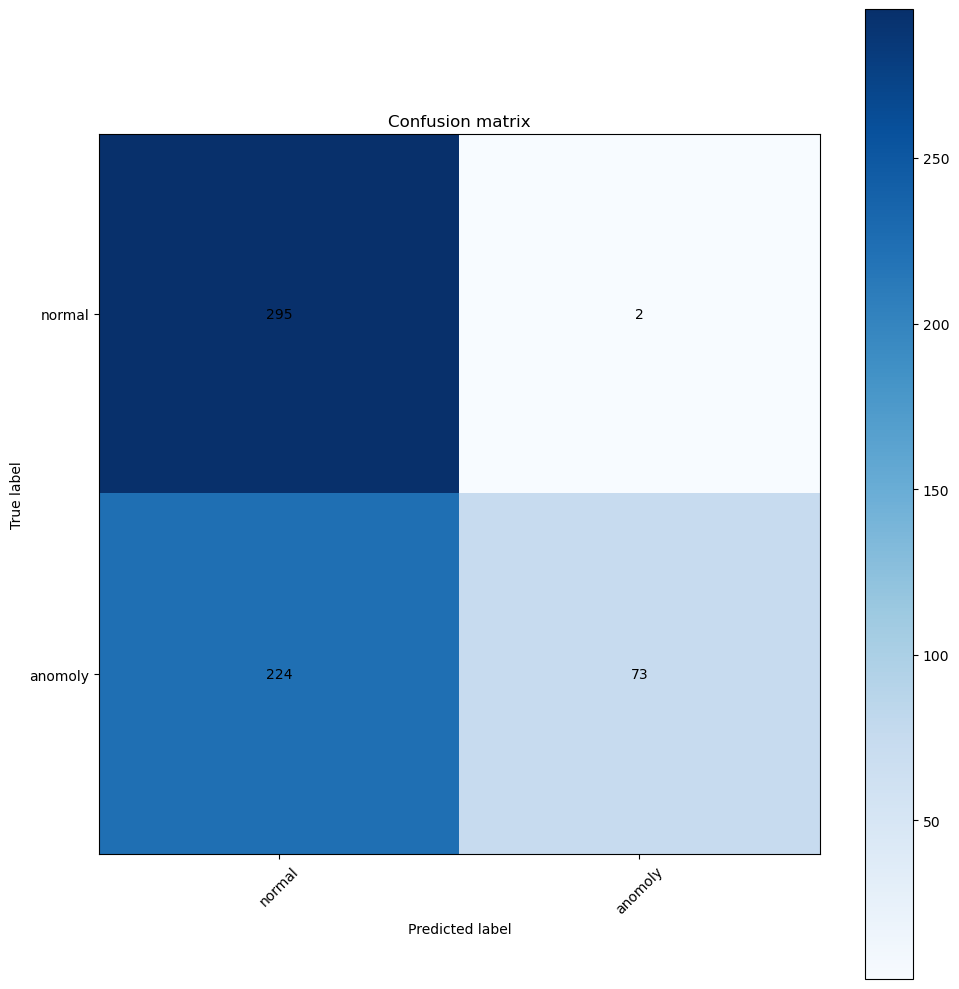


100%|██████████| 5200/5200 [02:26<00:00, 48.48it/s]

In [327]:
from sklearn.metrics import confusion_matrix
threshold = 0.7
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(df_test_y['anomaly'].values, y_pred_binary)  # Use y_pred_binary instead of y_pred

target_names = ['normal', 'anomoly']

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                         horizontalalignment='center',
                         verticalalignment='center')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, target_names)


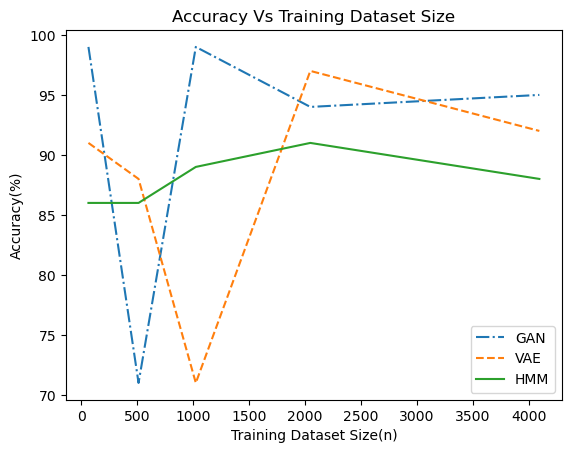

<Figure size 640x480 with 0 Axes>

In [364]:
import matplotlib.pyplot as plt
import numpy as np

fig1 = plt.gcf()

# create data
x = [64, 512, 1024, 2048, 4096]

y1 = [99, 71, 99, 94, 95]
y2 = [91, 88, 71, 97, 92]
y3 = [86, 86, 89, 91, 88]

# plot lines
plt.title('Accuracy Vs Training Dataset Size')
plt.ylabel('Accuracy(%)')
plt.xlabel('Training Dataset Size(n)')

plt.plot(x, y1, label="GAN", linestyle="-.")
plt.plot(x, y2, label="VAE", linestyle="--")
plt.plot(x, y3, label="HMM", linestyle="-")  # Changed linestyle to "-" here

plt.legend()
plt.savefig('dataset-size-vs-accuracy.svg', format='svg', dpi=1200)
plt.show()
plt.draw()


